In [342]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from PIL import Image
import numpy as np
import pandas as pd
import os
import random
import requests
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from requests.exceptions import RequestException
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [344]:
IMAGE_SIZE = (48, 48)
CONTRAST_THRESHOLD = 4.5
OUTPUT_DIR = "scraped_images"
SCREENSHOT_PATH = "full_page_screenshot.png"
FINAL_SCREENSHOT_PATH = "final_screenshot.png"
TARGET_ELEMENTS = []
X = []
Y = []

In [346]:
class URLClassifier:
    def __init__(self, model=None):
        self.dataset = self.read_dataset()
        
    def read_dataset(self):
        names = ['URL','Category']
        dataset = pd.read_csv('URL Classification.csv',names=names, na_filter=False)
        return dataset[:]

    def visualize_dataset(self):
        self.dataset.Category.value_counts().plot(figsize=(12,5),kind='bar',color='green');
        plt.xlabel('Category')
        plt.ylabel('Total Number Of Individual Category')

    def is_url_valid(self, url):
        try:
            response = requests.get(url, timeout=2)
            response.raise_for_status()
            return True
        except RequestException as e:
            print(f"Error fetching {url}: {e}")
            return False

    def remove_unreachable_urls(self):
        self.dataset["Valid"] = self.dataset["URL"].apply(self.is_url_valid)
        self.dataset = self.dataset[self.dataset["Valid"]].drop(columns=["Valid"]).reset_index(drop=True)

    def balance_dataset(self):
        category_counts = self.dataset.Category.value_counts()
        min_count = min(category_counts.min(), 10)
        
        self.dataset = (
            self.dataset
            .groupby('Category', group_keys=False)
            .apply(lambda x: x.sample(n=min_count, random_state=42))
            .reset_index(drop=True)
        ) 

        self.remove_unreachable_urls()

        category_counts = self.dataset.Category.value_counts()
        min_count = min(category_counts.min(), 5)
        
        self.dataset = (
            self.dataset
            .groupby('Category', group_keys=False)
            .apply(lambda x: x.sample(n=min_count, random_state=42))
            .reset_index(drop=True)
        ) 

    def get_dataset(self):
        return self.dataset

/var/folders/l7/rh36b8b54y5fl2ld7cs6fdrm0000gn/T/ipykernel_71700/2689360112.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_count, random_state=42))


Error fetching http://www.pussy-archive.com/: HTTPConnectionPool(host='www.pussy-archive.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x372245cd0>: Failed to resolve 'www.pussy-archive.com' ([Errno 8] nodename nor servname provided, or not known)"))
Error fetching http://www.km02.com/karenm/: 403 Client Error: Forbidden for url: http://www.km02.com/karenm/
Error fetching http://avs.thehardcorelounge.com/tb3/pudge/: 404 Client Error: Not Found for url: https://cams.hushcams.com/tag/cum/tb3/pudge/
Error fetching http://www.xxxnightdrive.com/topsites/index.php: 403 Client Error: Forbidden for url: http://www.xxxnightdrive.com/topsites/index.php
Error fetching http://www.nakedsword.com/: 403 Client Error: Forbidden for url: http://www.nakedsword.com/
Error fetching http://www.nirvanaprive.it/: HTTPConnectionPool(host='www.nirvanaprive.it', port=80): Max retries exceeded with url: / (Caused by NameResolutionErr

/var/folders/l7/rh36b8b54y5fl2ld7cs6fdrm0000gn/T/ipykernel_71700/2689360112.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_count, random_state=42))


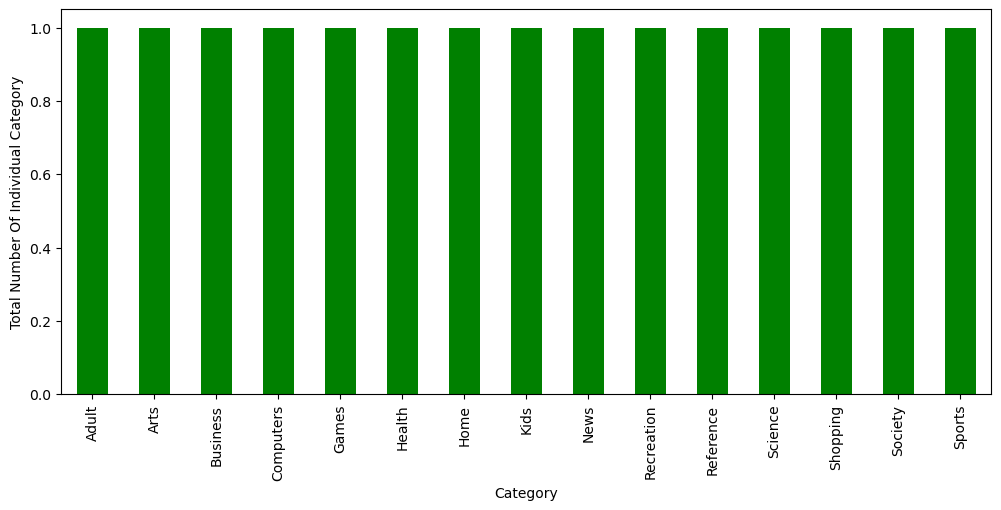

In [348]:
url_classifier = URLClassifier()
url_classifier.balance_dataset()
url_classifier.visualize_dataset()

In [350]:
class Model:
    def __init__(self, model=None):
        self.model = model
        self.driver = self._initialize_webdriver()
        self.selector_map = {}
        self.X = X
        self.y = Y

    def _initialize_webdriver(self):
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        chrome_options.add_argument("--no-sandbox")
        chrome_options.add_argument("--disable-dev-shm-usage")
        chrome_driver_path = '/opt/homebrew/bin/chromedriver'

        driver = webdriver.Chrome(service=Service(chrome_driver_path), options=chrome_options)
        driver.set_page_load_timeout(3)
        return driver

    def find_unique_xpath(self, element, soup):
        parts = []
        current = element

        while current and current.name != '[document]':
            if current.has_attr('id'):
                parts.insert(0, f"//{current.name}[@id='{current['id']}']")
                break
            
            if current.has_attr('class'):
                class_attr = ' '.join(current['class'])
                siblings = current.find_previous_siblings(name=current.name, class_=class_attr)
                index = len(siblings) + 1
                parts.insert(0, f"{current.name}[contains(@class, '{class_attr}')][{index}]")        
            else:
                siblings = current.find_previous_siblings(name=current.name)
                index = len(siblings) + 1
                parts.insert(0, f"{current.name}[{index}]")

            current = current.parent

        # Combine all parts into a full XPath, and replace triple slashes into double
        xpath = ("/" + "/".join(parts)).replace("///", "//")
        
        return xpath

    def calculate_contrast(self, image):
        """Calculate contrast ratio using WCAG guidelines."""
        pixel_values = np.array(image)
        min_intensity = pixel_values.min()
        max_intensity = pixel_values.max()
        
        l1 = (max_intensity + 0.05) / 255
        l2 = (min_intensity + 0.05) / 255
        contrast_ratio = (l1 + 0.05) / (l2 + 0.05) if l1 > l2 else (l2 + 0.05) / (l1 + 0.05)
        
        return contrast_ratio

    def screenshot_element(self, element):    
        """Takes a screenshot of the target element and saves it."""
        element_location = element.location
        element_size = element.size
        screenshot = Image.open(SCREENSHOT_PATH)
        screenshot_width, screenshot_height = screenshot.size
        
        element_left = element_location['x']
        element_top = element_location['y']
        element_right = min(screenshot_width, element_left + element_size['width']) 
        element_bottom = min(element_top + element_size['height'], screenshot_height)
        
        # Crop the image using Pillow
        cropped_image = screenshot.crop((element_left, element_top, element_right, element_bottom))

        if not os.path.exists(OUTPUT_DIR):
            os.makedirs(OUTPUT_DIR)
        
        element_screenshot_path = os.path.join(OUTPUT_DIR, f"screenshot_{random.randint(1, 1000000)}.png")
        cropped_image.save(element_screenshot_path)
        return element_screenshot_path

    def preprocess_image(self, image_path):
        """Resize and preprocess image for CNN."""
        try:
            image = Image.open(image_path).convert('L')        
            #image = image.resize((48, 48))
            image_array = np.array(image)
            return image_array
        except RequestException as e:
            return None

    def fetch_html(self, url):
        """Fetch the HTML of a webpage."""
        try:
            self.driver.get(url)
            time.sleep(3)
            response = requests.get(url, timeout=3)
            response.raise_for_status()  # Will raise an exception for HTTP errors
            return self.driver.page_source
        except RequestException as e:
            print(f"Error fetching {url}: {e}")

    def is_element_visible(self, element):
        try:        
            # Check if the element is displayed using is_displayed()
            if element.is_displayed():
                # Check if the element is within the viewport using JavaScript
                is_in_viewport = self.driver.execute_script("""
                    var elem = arguments[0];
                    var rect = elem.getBoundingClientRect();
                    return (
                        rect.top >= 0 &&
                        rect.left >= 0 &&
                        rect.bottom <= (window.innerHeight || document.documentElement.clientHeight) &&
                        rect.right <= (window.innerWidth || document.documentElement.clientWidth)
                    );
                """, element)
                
                if is_in_viewport:
                    return True
                else:
                    return False
            else:
                return False
        
        except TimeoutException:
            print("Timeout: Element not found or not visible within the timeout period.")
            return False
        except NoSuchElementException:
            print("Error: Element not found.")
            return False
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            return False

    def screenshot_full_page(self):
        window_size = self.driver.get_window_size()                            
        full_page_height = min(self.driver.execute_script("return document.documentElement.scrollHeight;"), 5000) 
        self.driver.set_window_size(window_size['width'],full_page_height)
        self.driver.save_screenshot(SCREENSHOT_PATH) 
        
        screenshot = Image.open(SCREENSHOT_PATH)
        screenshot_width, screenshot_height = screenshot.size
        
        ratio = screenshot_width / screenshot_height    
        screenshot = screenshot.resize((window_size['width'], int(window_size['width'] / ratio)))
        screenshot.save(SCREENSHOT_PATH)

    def extract_elements(self, soup, url):        
        for element in soup.find_all(TARGET_ELEMENTS):
            text = element.get_text(strip=True)
            if text:
                try:
                    selector = self.find_unique_xpath(element, soup)
                    driverElement = self.driver.find_element(By.XPATH, selector)
                    
                    if driverElement: 
                        is_visible = self.is_element_visible(driverElement)
                        
                        if (not is_visible):
                            continue
                            
                        self.categorize_element(driverElement, url)
                        self.selector_map[len(self.X)] = selector     
                except Exception as e:
                    print(f"{e}")

    def categorize_element(self, element, url):
        screenshot_path = self.screenshot_element(element)  
        image_array = self.preprocess_image(screenshot_path) 
        contrast_ratio = self.calculate_contrast(Image.fromarray(image_array.squeeze()))
        accessible = 1 if contrast_ratio >= CONTRAST_THRESHOLD else 0  
        image_array = image_array / 255.0 
        tag = element.tag_name
        
        self.X.append([image_array, tag, url])
        self.y.append(accessible)

    def scrape_site(self, link):      
        try:
            html_content = self.fetch_html(link)
            if html_content:
                self.screenshot_full_page()
                soup = BeautifulSoup(html_content, "html.parser")
                self.extract_elements(soup, link)
        except Exception as e:
            print(f"Error processing {link}: {e}")

    def process_data(self):
        try:
            url_dataset = url_classifier.get_dataset()
            links = url_dataset['URL']
            
            for link in links:
                self.scrape_site(link)

            self.X = np.array(self.X)
            self.y = np.array(self.y)
            X = self.X
            Y = self.y
        except Exception as e:
            print(e)

    def close_driver(self):
        """Close the web driver after processing."""
        self.driver.quit()

    def export_model(self, path):
        """Export the trained model to a file."""
        self.model.export(path)
    
    def cleanup(self):
        if os.path.isfile(SCREENSHOT_PATH):
            os.remove(SCREENSHOT_PATH)
        
        try:
            for filename in os.listdir(OUTPUT_DIR):
                file_path = os.path.join(OUTPUT_DIR, filename)
                if os.path.isfile(file_path):
                    os.remove(file_path)
            print("All files removed successfully.")
        except Exception as e:
            print(f"Error: {e}")

In [352]:
model = Model()
model.process_data()

Error processing http://www.neo-miracle.com/: Message: timeout: Timed out receiving message from renderer: 1.570
  (Session info: chrome=131.0.6778.70)
Stacktrace:
0   chromedriver                        0x00000001035795dc cxxbridge1$str$ptr + 3653648
1   chromedriver                        0x0000000103571e3c cxxbridge1$str$ptr + 3623024
2   chromedriver                        0x0000000102fdc100 cxxbridge1$string$len + 88404
3   chromedriver                        0x0000000102fc770c cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000102fc7494 cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000102fc5844 core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                        0x0000000102fc5f0c core::str::slice_error_fail::h1cab30ac4b13c655 + 62052
7   chromedriver                        0x0000000102fd3798 cxxbridge1$string$len + 53228
8   chromedriver                        0x0000000102fe6600 cxxbridge1$string$l

In [354]:
columns_X = ["image_array", "tag", "url"]
df = pd.DataFrame(model.X, columns=columns_X)
df["accessible"] = model.y

csv_file_path = "exported_data.csv"

# Export the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

In [195]:
model.X = X
model.y = Y

In [336]:
def balance_data():
    try:        
        samples_per_group = 1
        
        balanced_df = (
            df.groupby(["tag", "url"], group_keys=False)
            .apply(lambda x: x.sample(n=min(len(x), samples_per_group), random_state=42))
        )
        
        X_balanced = balanced_df[columns_X].values
        y_balanced = balanced_df["accessible"]
        
        model.X = X_balanced
        model.y = y_balanced
    except Exception as e:
        print(e)

def train_model():
    """Train the CNN model."""
    X_train, X_test, y_train, y_test = train_test_split(model.X, model.y, test_size=0.3, random_state=42)
    smote = SMOTE(sampling_strategy='auto', k_neighbors=4)
    X_flattened = np.array([x.flatten() for x in X_train])
    X_resampled, y_resampled = smote.fit_resample(X_flattened, y_train)  
    X_shaped = X_resampled.reshape(X_resampled.shape[0], *IMAGE_SIZE, 1)

    model.model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*IMAGE_SIZE, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    
    model.model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

    model.model.fit(X_shaped, y_resampled, epochs=40, validation_data=(X_test, y_test))
    loss, accuracy = model.model.evaluate(X_test, y_test)
    print(f"Loss: {loss}, Accuracy: {accuracy}")

    # Predict using the model
    y_pred = model.model.predict(X_test)
    
    # Convert the predictions to class labels (if necessary)
    y_pred_classes = np.argmax(y_pred, 1)
    y_true_classes = y_test.values
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Classification Report
    class_report = classification_report(y_true_classes, y_pred_classes)
    print("Classification Report:")
    print(class_report)

In [338]:
#balance_data()
#model.X = np.array([entry[0] for entry in model.X])
train_model()
model.export_model("HTMLConvolutional")
model.close_driver()
model.cleanup()

Epoch 1/40


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.4262 - loss: 0.7116 - val_accuracy: 0.4348 - val_loss: 0.7373
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5234 - loss: 0.7138 - val_accuracy: 0.4348 - val_loss: 0.6963
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4922 - loss: 0.6714 - val_accuracy: 0.4783 - val_loss: 0.6484
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6120 - loss: 0.6309 - val_accuracy: 0.8696 - val_loss: 0.5914
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8160 - loss: 0.5837 - val_accuracy: 0.6087 - val_loss: 0.5727
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7244 - loss: 0.5192 - val_accuracy: 0.9130 - val_loss: 0.4280
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7865 - loss: 0.4608 - val_accuracy: 0.8696 - val_loss: 0.3684
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8030 - loss: 0.4143 - val_accuracy: 0.8696 - val_loss: 0.3320
Epoch 9/40


INFO:tensorflow:Assets written to: HTMLConvolutional/assets


Saved artifact at 'HTMLConvolutional'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='keras_tensor_260')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  14857475024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14857475600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14857482896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14857471760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14857470032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14857483856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14857473488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14857472528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14857476752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14857473296: TensorSpec(shape=(), dtype=tf.resource, name=None)


All files removed successfully.
